In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:

def find_GH_with_tolerance(
    df_nwm,
    df_usgs,
    day_skip=7,
    day_bracket=7,
    q_tolerance=1.0,
    nwm_col="streamflow",
    usgs_q_col="discharge_cumecs",
    usgs_h_col="stage_ft",
):
    """
    For each NWM time t (after day_skip), search USGS data within [t - day_bracket, t + day_bracket].
    Take the mean of all USGS stages whose discharge lies within ±q_tolerance of the NWM discharge.
    If none match, return NaN. No interpolation.

    Parameters
    ----------
    df_nwm : DataFrame with DatetimeIndex and column nwm_col (default 'streamflow')
    df_usgs : DataFrame with DatetimeIndex and columns usgs_q_col ('discharge_cumecs'),
              usgs_h_col ('stage_ft')
    day_skip : days to skip from the start of df_nwm before processing
    day_bracket : half-window in days around each NWM time
    q_tolerance : discharge tolerance (same units as df_usgs[usgs_q_col])
    nwm_col, usgs_q_col, usgs_h_col : column names for flexibility
    """
    if not isinstance(df_nwm.index, pd.DatetimeIndex):
        raise TypeError("df_nwm must have a DatetimeIndex")
    if not isinstance(df_usgs.index, pd.DatetimeIndex):
        raise TypeError("df_usgs must have a DatetimeIndex")
    for col in [nwm_col]:
        if col not in df_nwm.columns:
            raise KeyError(f"df_nwm needs '{nwm_col}' column")
    for col in [usgs_q_col, usgs_h_col]:
        if col not in df_usgs.columns:
            raise KeyError(f"df_usgs needs '{usgs_q_col}' and '{usgs_h_col}' columns")

    # Keep needed cols and drop NaNs on USGS side
    nwm = df_nwm[[nwm_col]].copy()
    usgs = df_usgs[[usgs_q_col, usgs_h_col]].dropna().copy()

    # Sort by time for fast time-slicing
    nwm.sort_index(inplace=True)
    usgs.sort_index(inplace=True)

    # Apply day_skip
    start_time = nwm.index.min() + pd.Timedelta(days=day_skip)
    nwm_use = nwm.loc[nwm.index >= start_time].copy()

    out_records = []
    halfwin = pd.Timedelta(days=day_bracket)

    for t, row in nwm_use.iterrows():
        q = row[nwm_col]
        if pd.isna(q):
            out_records.append((t, np.nan))
            continue

        # Time window
        us = usgs.loc[t - halfwin : t + halfwin]
        if us.empty:
            out_records.append((t, np.nan))
            continue

        # Discharge band ± q_tolerance
        band = us[(us[usgs_q_col] >= q - q_tolerance) & (us[usgs_q_col] <= q + q_tolerance)]
        if band.empty:
            out_records.append((t, np.nan))
            continue

        gh_mean = float(band[usgs_h_col].mean())
        out_records.append((t, gh_mean))

    result = nwm.copy()
    gh_series = pd.DataFrame(out_records, columns=["time", "Computed_GH"]).set_index("time")
    result = result.join(gh_series, how="left")
    return result

In [108]:
df_NWM=pd.read_csv("/media/12TB/Sujan/NWM/Csv/01_Rulo/All/timeseries_006.csv")
df_NWM.index=pd.to_datetime(df_NWM['time'])
df_USGS=pd.read_csv("/media/12TB/Sujan/NWM/USGS_data/01_Rulo_06813500.csv")
df_USGS.index=pd.to_datetime(df_USGS['timestamp'])
df_NWM.columns, df_USGS.columns
out = find_GH_with_tolerance(df_NWM, df_USGS, day_skip=30, day_bracket=7, q_tolerance=1.0,
                             nwm_col="streamflow", usgs_q_col="discharge_cumecs", usgs_h_col="stage_ft")

In [109]:
#merge just the stage ft from the out with the usgs data to compare
merged = out.merge(
    df_USGS[['stage_ft']],
    left_index=True,
    right_index=True,
    how="inner",
    suffixes=("", "_usgs")
)
merged

,streamflow,Computed_GH,stage_ft
time,,,
2018-09-17 00:00:00,NaN,NaN,16.27
2018-09-17 06:00:00,2358.80,NaN,16.24
2018-09-17 12:00:00,2349.19,NaN,16.18
2018-09-17 18:00:00,2341.16,NaN,16.16
2018-09-18 00:00:00,2331.27,NaN,16.10
...,...,...,...
2024-12-30 00:00:00,660.75,3.772097,3.72
2024-12-30 06:00:00,660.47,3.772097,3.74
2024-12-30 12:00:00,660.53,3.772097,3.77


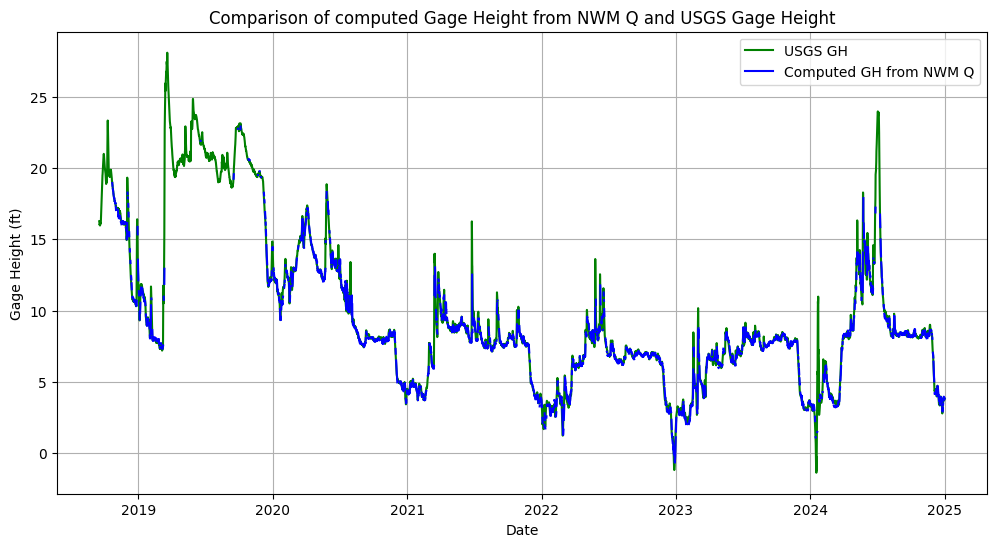

In [111]:
plt.figure(figsize=(12,6))
plt.plot(merged.index, merged['stage_ft'], label='USGS GH', color='green')
plt.plot(merged.index, merged['Computed_GH'], label='Computed GH from NWM Q', color='blue')
plt.xlabel('Date')
plt.ylabel('Gage Height (ft)')
plt.title('Comparison of computed Gage Height from NWM Q and USGS Gage Height')
plt.legend()
plt.grid()
plt.show()
